# BAO (DESI), SNe1a (PP), RDS, θ* : Flat LCDM

In [1]:
import os
from __future__ import division
import numpy as np
from numpy import *
from sys import *
import multiprocessing
import emcee
from scipy.optimize import minimize
from scipy import interpolate
from scipy.integrate import odeint
from scipy.integrate import quad
from math import log10
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
from numpy.linalg import multi_dot
from scipy.interpolate import interp1d
from scipy.constants import c
from multiprocessing import Pool
from getdist import plots, MCSamples
import getdist
import pickle
c_kms = c/1000
print(c_kms)


from scipy.interpolate import griddata


import time

# for monte carlo error propagation
from scipy.linalg import block_diag
from numpy.random import multivariate_normal as MN
import scipy.stats as st



299792.458


# DESI BAO Data Alone

In [2]:
# Prior knowledge

zd = 1059 # Redshift at drag epoch
Neff = 3.044 # number of neutrino degrees of freedom
wb = 0.02218 # Baryon density parameter 
wb_unc = 0.00055
om_ratio = wb/(2.469*10**(-5))
R = 3*wb/(4*2.469*10**(-5))
zm = 2.33


def omR(H0):
    return (1 + 0.2271*Neff) * 2.469 * 10**(-5)*(H0/100)**(-2) 

def X(z, x1, x2):
    '''quadratic DE density'''
    y = z/zm # or Visser: z/(1.+z)
    return 1. + (4.*x1 - x2 - 3.)*y -2.*(2.*x1 - x2 -1.)*y**2.
def DX(z, x1, x2):
    '''first derivative of quadratic DE density'''
    return ((4.*x1 - x2 - 3.)/zm) - (4.*(2.*x1 - x2 -1.)*z/(zm**2.))
def Hz(z, om, H0, x1, x2):
    return H0 * np.sqrt(om*(1.+z)**(3.0) + omR(H0)*(1.+z)**4 + (1 - om - omR(H0))*X(z, x1, x2))

def f(z, om, H0, x1, x2):
    return H0/Hz(z, om, H0, x1, x2)

def rr(z, om, H0, x1, x2):
    return quad(lambda x: f(x, om, H0, x1, x2), 0, z,)[0]

def dlh(z, om, H0, x1, x2):
    return rr(z, om, H0, x1, x2)*(1.0 + z)

# Define the function to integrate for drag-epoch sound horizon

def cs(z):
    return c_kms/np.sqrt(3.*(1. + (R/(1. + z))))
def rd2(z, om, H0, x1, x2):
    return quad(lambda x: (cs(x)/Hz(x, om, H0, x1, x2)), z, np.inf,)[0]


In [3]:
# We define the BAO theoretical functions

def dm(x, om, H0, x1, x2):
    return (299792.458/H0)*rr(x, om, H0, x1, x2)

def dh(x, om, H0, x1, x2):
    return 299792.458/Hz(x, om, H0, x1, x2)

def dv(x, om, H0, x1, x2):
    t1 = dm(x, om, H0, x1, x2)**2 * dh(x, om, H0, x1, x2) * x
    return t1**(1./3.)

In [4]:
# The chi^2 for each DESI component

# BGS
def chi2a(om, H0, x1, x2):
    t1 = (dv(0.295, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2) -7.93)/0.15
    return t1**2

################################################################
# LRG 1
covmatb = [[0.0625, -0.0678625],[-0.0678625, 0.3721]]
inv_covb = np.linalg.inv(covmatb)

def chi2b(om, H0, x1, x2):
    resid = np.array([dm(0.510, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2) -13.62, dh(0.510, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2) -20.98])
    return resid.T@inv_covb@resid


################################################################
# LRG2
covmatc = [[0.1024, -0.08064],[-0.08064, 0.36]]
inv_covc = np.linalg.inv(covmatc)

def chi2c(om, H0, x1, x2):
    resid = np.array([dm(0.706, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-16.85, dh(0.706, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-20.08])
    return resid.T@inv_covc@resid


################################################################
# LRG+ELG
covmatd = [[0.0784, -0.038122],[-0.038122, 0.1225]]
inv_covd = np.linalg.inv(covmatd)

def chi2d(om, H0, x1, x2):
    resid = np.array([dm(0.930, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-21.71, dh(0.930, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-17.88])
    return resid.T@inv_covd@resid


################################################################
# ELG
covmate = [[0.4761, -0.1286712],[-0.1286712, 0.1764]]
inv_cove = np.linalg.inv(covmate)

def chi2e(om, H0, x1, x2):
    resid = np.array([dm(1.317, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-27.79, dh(1.317, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-13.82])
    return resid.T@inv_cove@resid


################################################################
# QSO
def chi2f(om, H0, x1, x2):
    t1 = (dv(1.491, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-26.07)/0.67
    return t1**2


################################################################
# Lya QSO
covmatg = [[0.8836, -0.0762246],[-0.0762246, 0.0289]]
inv_covg = np.linalg.inv(covmatg)

def chi2g(om, H0, x1, x2):
    resid = np.array([dm(2.330, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-39.71, dh(2.330, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-8.52])
    return resid.T@inv_covg@resid

In [5]:
def chitotal(H0, om, x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    return BAO

def lnprior(theta):
    H0, om, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, x1, x2 = theta
	model = chitotal(H0, om, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)
    

In [6]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[68, 0.3, 0.36, -1.76],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO', rest.x)
result=rest.x
print("BAO: chi-squared =", -2*lnprob(result))
print("BAO: reduced chi-squared =",-2*lnprob(result)/(12-4))

searching the initial position ...
minimization 0.5*chi2 for BAO [175.40580582   0.77178298 -16.66355292 -66.48268655]
BAO: chi-squared = 11.214291553095242
BAO: reduced chi-squared = 1.4017864441369052


In [7]:
#ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
#ndim, nwalkers = 4, 10
#nburn=20
#nmcmc=1000

#dres=[0.1, 0.01, 0.01, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
#pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# #Clear and run the production chain.
#print("Running MCMC for DESI BAO ...")
#pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")

## RDS Data Alone

In [6]:
# Adding growth pertubations data sets

datagf=loadtxt('Growth_tableII.txt',float)

# Redshift Space Distortions (RDS) sample
zgf = datagf[:,0]
gf  = datagf[:,1]
sgf = datagf[:,2]


#### RDS: Equation (2.5) for flat LCDM

In this case we solve for $\delta (a) $ given by the solution to

$$ \delta''+\left(\frac{3}{a}+ \frac{E'(a)}{E(a)} \right)\delta' - \frac{3}{2} \frac{\Omega_{0m}}{a^5E(a)^2} \delta = 0
$$

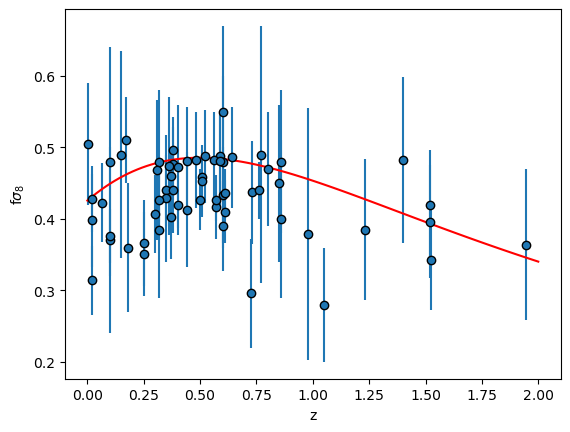

In [7]:
def model(delta, a, Omega0m, x1, x2):
    z = (1./a) - 1
    H = np.sqrt(Omega0m/a**3. + (1. - Omega0m)*X(z, x1, x2))
    H_prime = -1. * (1.+z)**(2.0)*(3.*Omega0m*(1.+z)**(2.0) + (1 - Omega0m) *DX(z, x1, x2))/(2.*H)

    delta_prime = delta[1]
    delta_double_prime = -((3./a) + H_prime/H)*delta[1] + (1.5*Omega0m*delta[0]/(a**5*H**2))

    return [delta_prime, delta_double_prime]
# Initial conditions
delta0 = 0.001  # initial value of delta
delta_prime0 = 1.0  # initial value of delta'


def Dadp(aa, Omega0m, x1, x2):
    # Solve the ODE
    a_values = np.linspace(0.001, 1, 1000)  # values of 'a' where you want to solve the ODE
    delta_solution = odeint(model, [delta0, delta_prime0], a_values, args=(Omega0m, x1, x2))
    delta_values, delta_prime_values = delta_solution[:, 0], delta_solution[:, 1]
    interpolation_delta = interp1d(a_values, delta_values, kind='linear', fill_value='extrapolate')
    interpolation_delta_prime = interp1d(a_values, delta_prime_values, kind='linear', fill_value='extrapolate')
    # Specify the x value for which you want to find the interpolated f value
    delta_f = interpolation_delta(aa)
    deltap_f = interpolation_delta_prime(aa)
    result = delta_f, deltap_f
    return result

def fa(aa, Omega0m, x1, x2):
    deltas = Dadp(aa, Omega0m, x1, x2)
    result = aa*deltas[1]/deltas[0]
    return result

def fs8z(z, Omega0m, sig8, x1, x2):
    aa = 1./(1.+z)
    deltas = Dadp(aa, Omega0m, x1, x2)
    daen1 = Dadp(1, Omega0m, x1, x2)
    t1 = sig8*deltas[0]*fa(1./(1.+z), Omega0m, x1, x2)
    t2 = t1/daen1[0]
    return t2

# Plot the data + theory (using best fit found below)
x = np.linspace(0, 2, 100)
fs8zd = fs8z(x, 0.31, 0.81, 0.36, -1.7)
pl.errorbar(zgf,gf,sgf,fmt='o',markeredgecolor='k')
pl.plot(x, fs8zd, color='red')
pl.xlabel('z')
pl.ylabel('f$\sigma_8$')
#pl.savefig('growthdata.png')    
pl.show()

In [8]:
# Chi squared minimization for RDS

def chi2_RDS(om, sig8, x1, x2):
    model = fs8z(zgf, om, sig8, x1, x2)
    inv_sigma2 = 1/(sgf**2)
    return np.sum(((gf - model)**2)*inv_sigma2)

def chi_total(om, sig8, x1, x2):
     return chi2_RDS(om, sig8, x1, x2)

def lnprior(theta):
    om, sig8, x1, x2 = theta
    if 0.1 < om < 0.5:
        return 0.0
    return -np.inf

def lnlike(theta):
	om, sig8, x1, x2 = theta
	model = chi_total(om, sig8, x1, x2)
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [28]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[0.31, 0.8, 0.36, -1.7],method='Nelder-Mead')
print('minimization 0.5*chi2 for RDS', rest.x)
result=rest.x
print("RDS: chi-squared =", -2*lnprob(result))
print("RDS: reduced chi-squared =",-2*lnprob(result)/(63-4))

searching the initial position ...
minimization 0.5*chi2 for RDS [0.19164971 0.99109573 3.14041509 8.98910063]
RDS: chi-squared = 30.862335436332945
RDS: reduced chi-squared = 0.5230904311242872


In [29]:
# ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
# ndim, nwalkers = 4, 10
# nburn=20
# nmcmc=1000

# dres=[0.01, 0.01, 0.01, 0.01]



# #pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# # Clear and run the production chain.
# print("Running MCMC for RDS data ...")


# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")

Running MCMC for RDS data ...


/var/folders/dp/5tsws8qd3bs17fw1r1gj51k80000gn/T/ipykernel_63664/3031575096.py:18: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  delta_solution = odeint(model, [delta0, delta_prime0], a_values, args=(Omega0m, x1, x2))
/var/folders/dp/5tsws8qd3bs17fw1r1gj51k80000gn/T/ipykernel_63664/3031575096.py:38: RuntimeWarning: overflow encountered in divide
  t2 = t1/daen1[0]


Done.


Removed no burn in
MCMC result:
    $\Omega_M$  = 0.18964238619284624 + 0.1304882039737496 -0.061273235650589813
    $\Sigma_8$  = 1.0094123135604378 + 0.29802500078515415 -0.2508053724082715
    $x1$        = 3.2629769890500495 + 1.777739566119814 -2.686374488332306
    $x2$        = 9.191909801728787 + 7.152337287157099 -11.025695213873371



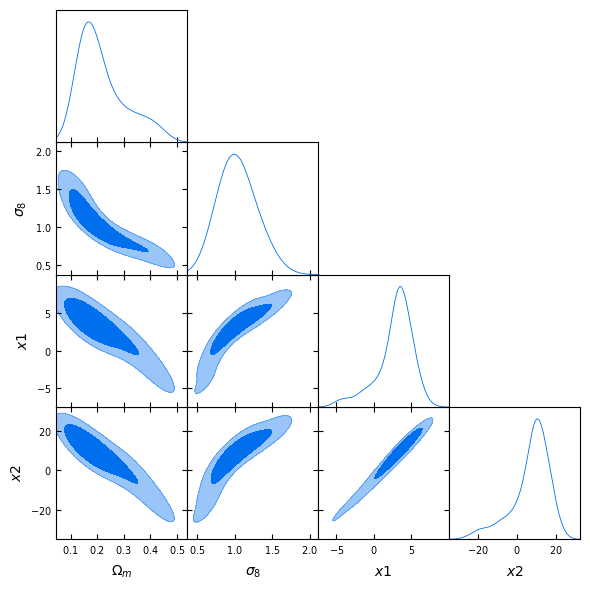

In [30]:
# # Here we neglect the first burnin samples
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# names = ["\Omega_m", "\sigma_8", "x1", "x2"]
# labels = ["\Omega_m", "\sigma_8", "x1", "x2"]

# samples = MCSamples(samples=samps, names=names, labels=labels)
# # Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# #pl.figure(figsize=(50,30))z
# g.triangle_plot([samples], filled=True)
# #g.export('hrd_vs_om_case_all.pdf')
# # Compute the quantiles.
# om_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#     $\Omega_M$  = {0[0]} + {0[1]} -{0[2]}
#     $\Sigma_8$  = {1[0]} + {1[1]} -{1[2]}
#     $x1$        = {2[0]} + {2[1]} -{2[2]}
#     $x2$        = {3[0]} + {3[1]} -{3[2]}
# """.format(om_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc))

## SN1a Data Alone

In [9]:
# Adding the Pantheon+SH0ES & Growth pertubations data sets

loc_lcparam = 'Pantheon+SH0ES.dat.txt'
lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11, 12, 13))
datagf=loadtxt('Growth_tableII.txt',float)

# Pantheon+ SN1a samples
z_pp = lcparam[:, 0]
mz_pp = lcparam[:, 1]
sigmz_pp = lcparam[:, 2]

mMz_pp = lcparam[:, 3]
sigmMz_pp = lcparam[:, 4]

muceph_pp = lcparam[:,5] # mu values calibrated using cepheids
hostyn_pp = lcparam[:,6] # 1 if calibrated, 0 if not

# Pantheon+ systematics
loc_lcparam_sys = 'Pantheon+SH0ES_STAT+SYS.cov.txt'
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)
cov_pp_tot = lcparam_sys.reshape(1701, 1701)
inv_cov_pp = np.linalg.inv(cov_pp_tot)  # Covariance matrix inverse


In [10]:
# Definining theoretical function for SNe1a data

def dlh(z, om, H0, x1, x2):
    return rr(z, om, H0, x1, x2)*(1.0 + z)
def mMz_qd(z, H0, om, x1, x2):
    '''distance modulus prediction'''
    h_1 = H0/100
    return 5*np.log10((c/h_1)*dlh(z, om, H0, x1, x2))

def mz_qd(z, H0, om, M, x1, x2):
    '''apparent magnitude prediction'''
    return mMz_qd(z, H0, om, x1, x2) + M

In [11]:
# minimizing chi squared for SNE

def chi2_SN1a(H0, om, M, x1, x2):
    dm = np.zeros(len(z_pp))
    for i in range(0, len(z_pp)):
        if hostyn_pp[i] == 1:
            dm[i] = mz_pp[i] - M - muceph_pp[i] # SH0ES calibrated \mu
        else:
            dm[i] = mz_pp[i] - mz_qd(z_pp[i], H0, om, M, x1, x2)
    
    chi2 = dm @ inv_cov_pp @ dm
    return chi2


def chitotal(H0, om, M, x1, x2):
    SN1a = chi2_SN1a(H0, om, M, x1, x2)
    return SN1a

def lnprior(theta):
    H0, om, M, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M, x1, x2 = theta
	model = chitotal(H0, om, M, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)
    


In [ ]:

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[73, 0.3, -19, 0.36, -1.7],method='Nelder-Mead')
print('minimization 0.5*chi2 for SNIa', rest.x)
result=rest.x
print("SN1a: chi-squared =", -2*lnprob(result))
print("SN1a: reduced chi-squared =",-2*lnprob(result)/(1701-5))

In [35]:
# ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
# ndim, nwalkers = 5, 10
# nburn=20
# nmcmc=1000

# dres=[0.1, 0.01, 0.1, 0.01, 0.01]

# #pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# # Clear and run the production chain.
# print("Running MCMC for SN1a data ...")
# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")

Running MCMC for SN1a data ...
Done.


Removed no burn in


MCMC result:
    $H0$        = 73.32562215960581 + 1.1186095388884496 -0.975184876234465
    $\Omega_M$  = 0.48270598336217563 + 0.12943910005554982 -0.13052057771701164
    $M$         = -19.243772745038733 + 0.027573294217450695 -0.03001517146250876
    $x1$        = -1.5547318137955863 + 1.8704784977041595 -4.229657934742084
    $x2$        = -7.71429776488751 + 5.729241528847945 -15.003577876983195




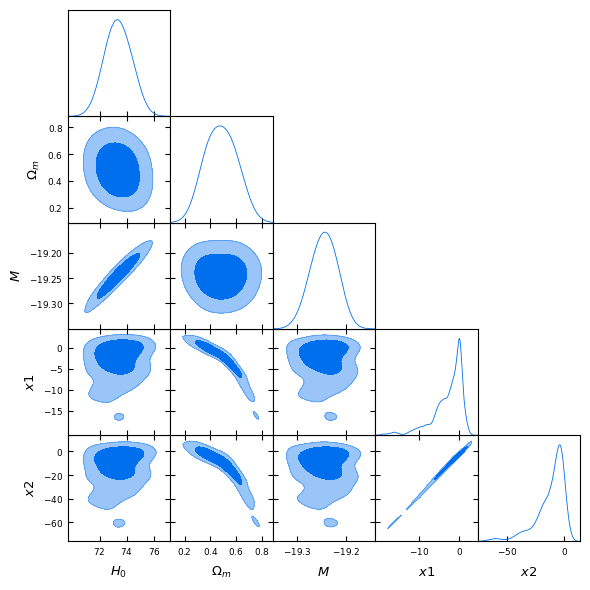

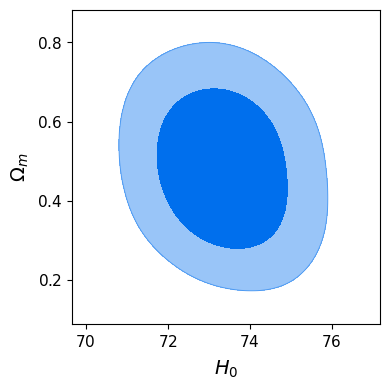

In [36]:
# # Here we neglect the first burnin samples
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# # Get the getdist MCSamples objects for the samples, specifying same parameter
# # names and labels; if not specified weights are assumed to all be unity

# names = ["H_0", "\Omega_m", "M", "x1", "x2"]
# labels = ["H_0", "\Omega_m", "M", "x1", "x2"]

# samples = MCSamples(samples=samps, names=names, labels=labels)

# # Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# #pl.figure(figsize=(50,30))z
# g.triangle_plot([samples], filled=True)
# g.export('hrd_vs_om_case_all.pdf')

# # Filled 2D comparison plot with legend
# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
# #g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# # Compute the quantiles.

# h0_mcmc, om_mcmc, M_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#     $H0$        = {0[0]} + {0[1]} -{0[2]}
#     $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
#     $M$         = {2[0]} + {2[1]} -{2[2]}
#     $x1$        = {3[0]} + {3[1]} -{3[2]}
#     $x2$        = {4[0]} + {4[1]} -{4[2]}

# """.format(h0_mcmc, om_mcmc, M_mcmc, x1_mcmc, x2_mcmc))


## BAO + RDS

In [37]:
def chitotal(H0, om, sig8, x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    RDS = chi2_RDS(om, sig8, x1, x2)
    return BAO + RDS

def lnprior(theta):
    H0, om, sig8, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, sig8, x1, x2 = theta
	model = chitotal(H0, om, sig8, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)

from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, 0.8, 0.36, -1.7],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + RDS', rest.x)
result=rest.x
print("BAO+RDS: chi-squared =", -2*lnprob(result))
print("BAO+RDS: reduced chi-squared =",-2*lnprob(result)/(75-5))

searching the initial position ...
minimization 0.5*chi2 for BAO + RDS [68.60854144  0.27940403  0.77776488  1.04617862  1.28100223]
BAO+RDS: chi-squared = 44.883462101813386
BAO+RDS: reduced chi-squared = 0.6411923157401912


In [38]:
# ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
# ndim, nwalkers = 5, 10
# nburn=20
# nmcmc=1000

# dres=[0.1, 0.01, 0.01, 0.01, 0.01]

# #pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# # Clear and run the production chain.
# print("Running MCMC for BAO + RDS data ...")
# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")

Running MCMC for BAO + RDS data ...
Done.


Removed no burn in
MCMC result:
    $H0$        = 70.24057570183271 + 12.633397928938479 -5.109435751586602
    $\Omega_M$  = 0.30037221500998595 + 0.08867005267020517 -0.049808498575672655
    $\sigma_8$  = 0.7575286564609789 + 0.06151391874688905 -0.08370888957327782
    $x1$        = 0.8732408141851831 + 0.57910627875368 -1.501993396474306
    $x2$        = 0.5976257090922437 + 2.076718006362083 -5.396545909063157




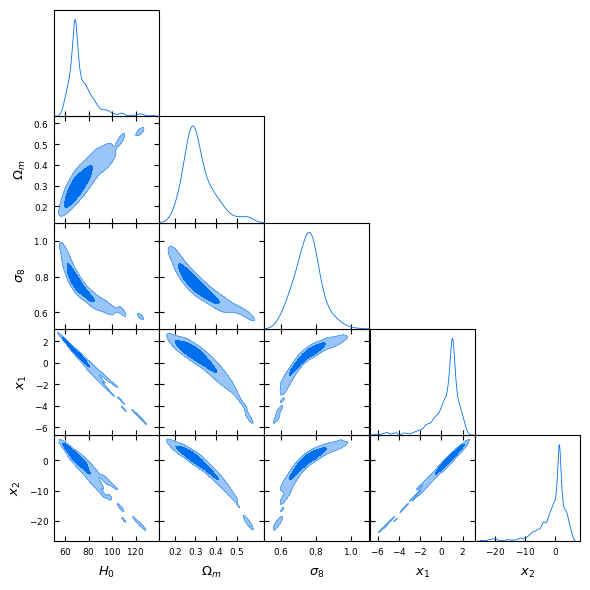

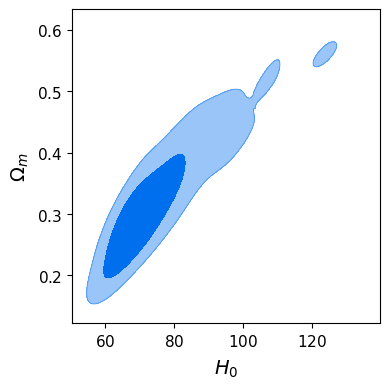

In [41]:
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
# names = ["H_0", "\Omega_m", "\sigma_8", "x_1", "x_2"]
# labels = ["H_0", "\Omega_m", "\sigma_8", "x_1", "x_2"]

# samples = MCSamples(samples=samps, names=names, labels=labels)

# # Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# g.triangle_plot([samples], filled=True)
# g.export('hrd_vs_om_case_all.pdf')

# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
# #g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# # Compute the quantiles.
# h0_mcmc, om_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#     $H0$        = {0[0]} + {0[1]} -{0[2]}
#     $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
#     $\sigma_8$  = {2[0]} + {2[1]} -{2[2]}
#     $x1$        = {3[0]} + {3[1]} -{3[2]}
#     $x2$        = {4[0]} + {4[1]} -{4[2]}

# """.format(h0_mcmc, om_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc))


## BAO + SN1a

In [42]:
# Combining chi squares for each dataset

def chitotal(H0, om, M, x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    SN1a = chi2_SN1a(H0, om, M, x1, x2)
    return BAO + SN1a 

def lnprior(theta):
    H0, om, M, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M, x1, x2 = theta
	model = chitotal(H0, om, M, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)
    
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, -19, 0.36, -1.7],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + SN1a', rest.x)
result=rest.x
print("BA0+SN1a: chi-squared =", -2*lnprob(result))
print("BAO+SN1a: reduced chi-squared =",-2*lnprob(result)/(1713-5))

searching the initial position ...
minimization 0.5*chi2 for BAO + SN1a [ 73.35645112   0.35162415 -19.24607684   0.36295469  -1.7589961 ]
BA0+SN1a: chi-squared = 1535.9028370841868
BAO+SN1a: reduced chi-squared = 0.8992405369345355


In [43]:
# ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
# ndim, nwalkers = 5, 10
# nburn=20
# nmcmc=1000

# dres=[0.1, 0.01, 0.01, 0.01, 0.01]

# #pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# # Clear and run the production chain.
# print("Running MCMC for BAO + SN1a data ...")
# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")

Running MCMC for BAO + SN1a data ...
Done.


Removed no burn in
MCMC result:
    $H0$        = 73.4523019209322 + 0.9081069558775852 -0.9192743932134704
    $\Omega_M$  = 0.35398962072810586 + 0.015691356553016178 -0.016763407899741456
    $M$         = -19.243145299794314 + 0.027194977079357585 -0.027780061741161433
    $x1$        = 0.3359108016101042 + 0.1709418642794267 -0.14274824232140645
    $x2$        = -1.829909621791794 + 0.7432137332801432 -0.7270008559467571




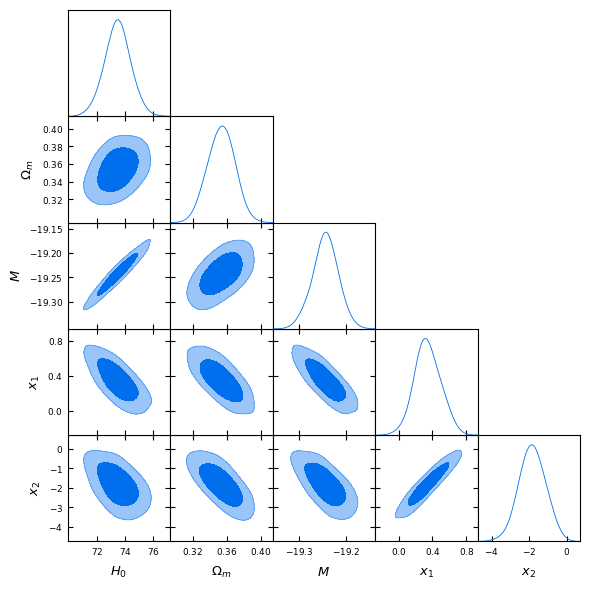

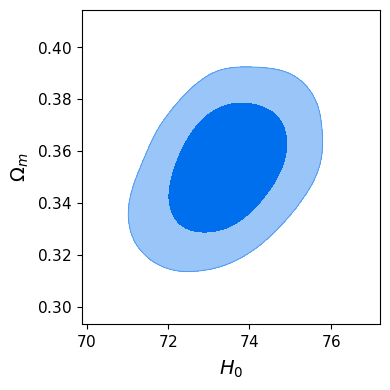

In [44]:
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
# names = ["H_0", "\Omega_m", "M", "x_1", "x_2"]
# labels = ["H_0", "\Omega_m", "M", "x_1", "x_2"]

# samples = MCSamples(samples=samps, names=names, labels=labels)

# # Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# g.triangle_plot([samples], filled=True)
# g.export('hrd_vs_om_case_all.pdf')

# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
# #g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# # Compute the quantiles.
# h0_mcmc, om_mcmc, M_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#     $H0$        = {0[0]} + {0[1]} -{0[2]}
#     $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
#     $M$         = {2[0]} + {2[1]} -{2[2]}
#     $x1$        = {3[0]} + {3[1]} -{3[2]}
#     $x2$        = {4[0]} + {4[1]} -{4[2]}

# """.format(h0_mcmc, om_mcmc, M_mcmc, x1_mcmc, x2_mcmc))


## BAO + RDS + SN1a 

In [12]:
# Combining chi squares for each dataset

def chitotal(H0, om, M, sig8,  x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    SN1a = chi2_SN1a(H0, om, M, x1, x2)
    RDS = chi2_RDS(om, sig8, x1, x2)
    return BAO + SN1a + RDS

def lnprior(theta):
    H0, om, M, sig8, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M, sig8, x1, x2 = theta
	model = chitotal(H0, om, M, sig8, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)



In [13]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, -19, 0.8, 0.36, -1.7],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + SN1a + RDS', rest.x)
result=rest.x
print("BAO+RDS+SN1a: chi-squared =", -2*lnprob(result))
print("BAO+RDS+SN1a: reduced chi-squared =",-2*lnprob(result)/(1776-4))

searching the initial position ...
minimization 0.5*chi2 for BAO + SN1a + RDS [ 73.21391075   0.34998729 -19.25112139   0.72083727   0.37241869
  -1.6971461 ]
BAO+RDS+SN1a: chi-squared = 1568.0916890468222
BAO+RDS+SN1a: reduced chi-squared = 0.884927589755543


In [51]:
from statsmodels.stats.stattools import durbin_watson

print("BAO+RDS+SN1a: DW statistic =", durbin_watson(resids(73.247679, 0.34627041,-19.25060603, 0.72319747, 0.38942928,  -1.6593511 )))


BAO+RDS+SN1a: DW statistic = 1.7245167981230354


In [14]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 6, 12
nburn=20
nmcmc=5000

dres=[0.1, 0.01, 0.1, 0.01, 0.01, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)


from multiprocessing import Pool

print("Running MCMC...")
with Pool() as pool:
    sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    pos1=sampler1.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
    sampler1.run_mcmc(pos1, nmcmc, progress=True)




# Clear and run the production chain.
#print("Running MCMC for BAO + SN1a + RDS data ...")
#pos1=sampler1.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#sampler1.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")

Running MCMC...


100%|███████████████████████████████████████| 5000/5000 [57:02<00:00,  1.46it/s]


Removed no burn in
MCMC result:
    $H0$        = 73.16076079810944 + 0.974842738187661 -0.9240983813922412
    $\Omega_M$  = 0.35046485754598733 + 0.014467999730614967 -0.014107765304033737
    $M$         = -19.25244275139095 + 0.0293123745302033 -0.02743871020859956
    $\Sigma_8$  = 0.7201355712837338 + 0.01677580802542722 -0.01611943555554718
    $x1$        = 0.3808826566375344 + 0.14763024611959363 -0.15496458621659473
    $x2$        = -1.6737920509462512 + 0.6549376174325594 -0.6860700185903268




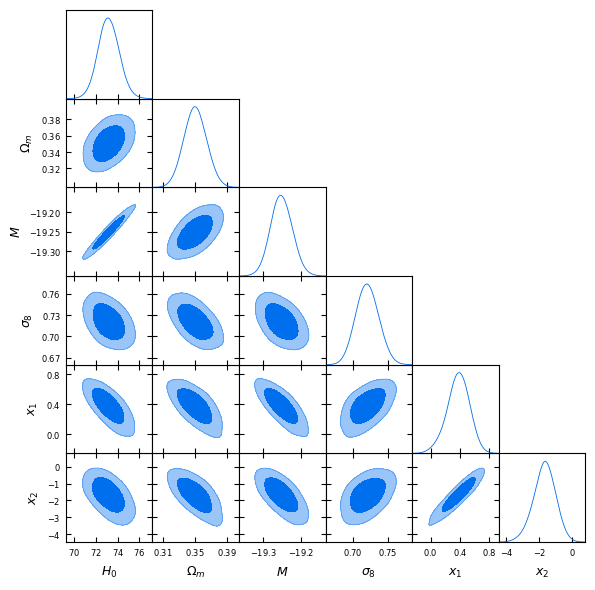

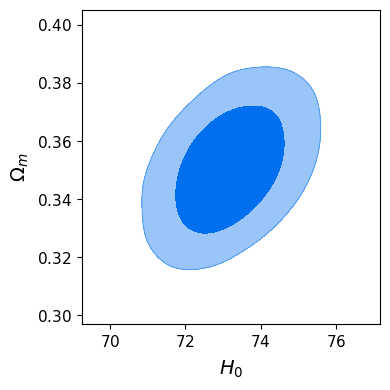

In [16]:
# Here we neglect the first burnin samples
burnin = 20
samps1 = sampler1.chain[:, burnin:, :].reshape((-1, ndim))

# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names1 = ["H_0", "\Omega_m", "M", "\sigma_8", "x_1", "x_2"]
labels1 = ["H_0", "\Omega_m", "M", "\sigma_8", "x_1", "x_2"]

samples1 = MCSamples(samples=samps1, names=names1, labels=labels1)

# Triangle plot
g = plots.get_subplot_plotter(width_inch=6)
#pl.figure(figsize=(50,30))z
g.triangle_plot([samples1], filled=True)
g.export('hrd_vs_om_case_all.pdf')

# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([samples1], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Compute the quantiles.

h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samps1, [16, 50, 84],
                                               axis=0)))
print("""MCMC result:
    $H0$        = {0[0]} + {0[1]} -{0[2]}
    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
    $M$         = {2[0]} + {2[1]} -{2[2]}
    $\Sigma_8$  = {3[0]} + {3[1]} -{3[2]}
    $x1$        = {4[0]} + {4[1]} -{4[2]}
    $x2$        = {5[0]} + {5[1]} -{5[2]}

""".format(h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc ))


# # Theta* Alone

In [17]:
# Additional Priors: acoustic angular scale & drag-epoch sound horizon

# Defining the acoustic angular scale
z_recomb = 1090
def angle(z, om, H0, x1, x2):
    return 100*rd2(z, om, H0, x1, x2)/dm(z, om, H0, x1, x2)

def chitotal(om, H0, x1, x2):
    return ((angle(z_recomb, om, H0, x1, x2)-1.04109)/0.00030)**2.

def lnprior(theta):
    om, H0, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	om, H0, x1, x2 = theta
	model = chitotal(om, H0, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)


In [13]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[0.3, 70, 0.5, -0.5],method='Nelder-Mead')
print('minimization 0.5*chi2 for theta*', rest.x)
result=rest.x
print("theta: chi-squared =", -2*lnprob(result))
print("theta: reduced chi-squared =",-2*lnprob(result)/(1-2))

searching the initial position ...
minimization 0.5*chi2 for theta* [ 0.30480065 71.65470898  0.50829657 -0.4885828 ]
theta: chi-squared = 8.616195543867445e-10
theta: reduced chi-squared = -8.616195543867445e-10


In [ ]:
# ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
# ndim, nwalkers = 4, 10
# nburn=20
# nmcmc=1000

# dres=[0.01, 0.1, 0.01, 0.01]

# #pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# # Clear and run the production chain.
# print("Running MCMC for theta*...")
# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")


In [ ]:
# # Here we neglect the first burnin samples
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# # Get the getdist MCSamples objects for the samples, specifying same parameter
# # names and labels; if not specified weights are assumed to all be unity

# names = ["\Omega_m", "H_0", "x_1", "x_2"]
# labels = ["\Omega_m", "H_0", "x_1", "x_2"]

# samples = MCSamples(samples=samps, names=names, labels=labels)

# # Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# #pl.figure(figsize=(50,30))z
# g.triangle_plot([samples], filled=True)
# g.export('hrd_vs_om_case_all.pdf')

# # Filled 2D comparison plot with legend
# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
# #g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# # Compute the quantiles.

# om_mcmc, h0_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#     $\Omega_M$  = {0[0]} + {0[1]} -{0[2]}
#     $H0$        = {1[0]} + {1[1]} -{1[2]}
#     $x1$        = {2[0]} + {2[1]} -{2[2]}
#     $x2$        = {3[0]} + {3[1]} -{3[2]}
# """.format(om_mcmc, h0_mcmc, x1_mcmc, x2_mcmc))

# print(omR(67.48920691828434))

# # Combining theta* w/ 3 datasets

In [18]:

def chitotal(H0, om, M, sig8, x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    SN1a = chi2_SN1a(H0, om, M, x1, x2)
    RDS = chi2_RDS(om, sig8, x1, x2)
    return BAO + SN1a + RDS + ((angle(z_recomb, om, H0, x1, x2)-1.04109)/0.00030)**2.

def lnprior(theta):
    H0, om, M, sig8, x1, x2 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M, sig8, x1, x2 = theta
	model = chitotal(H0, om, M, sig8, x1, x2)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)

In [19]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, -19, 0.8, 0.36, -1.7],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + SN1a + RDS + theta', rest.x)
result=rest.x
print("BAO+RDS+SN1a+theta: chi-squared =", -2*lnprob(result))
print("BAO+RDS+SN1a+theta: reduced chi-squared =",-2*lnprob(result)/(1776-6))

#Not changing significantly based on starting x1 and x2 positions

searching the initial position ...
minimization 0.5*chi2 for BAO + SN1a + RDS + theta [ 71.83057363   0.33029403 -19.29115083   0.73505248   0.43796928
  -1.77232356]
BAO+RDS+SN1a+theta: chi-squared = 1575.071047191044
BAO+RDS+SN1a+theta: reduced chi-squared = 0.8898706481305334


In [20]:

ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 6, 12
nburn=20
nmcmc=5000

dres=[0.1, 0.01, 0.1, 0.01, 0.01, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

from multiprocessing import Pool

print("Running MCMC...")
with Pool() as pool:
    sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    pos1=sampler2.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
    sampler2.run_mcmc(pos1, nmcmc, progress=True)


# Clear and run the production chain.
# print("Running MCMC for BAO + SN1a + RDS + theta data ...")
# pos1=sampler2.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler2.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")


Running MCMC...


100%|███████████████████████████████████████| 5000/5000 [57:43<00:00,  1.44it/s]


Removed no burn in
MCMC result:
    $H0$        = 71.83656823985217 + 0.8658231182153742 -0.8166895349836238
    $\Omega_M$  = 0.332320124863556 + 0.011311921017852722 -0.01081674196300686
    $M$         = -19.290170781146056 + 0.025970832831234247 -0.024796642255502377
    $\Sigma_8$  = 0.7340826044535839 + 0.015476694565954463 -0.014967879644624316
    $x1$        = 0.4205778112347315 + 0.14698972333200544 -0.1521545623160428
    $x2$        = -1.8461012461607749 + 0.6082886016077493 -0.682727230885932




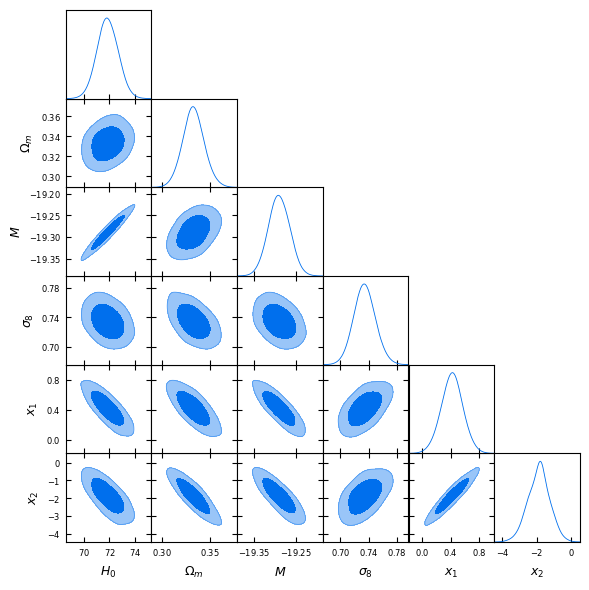

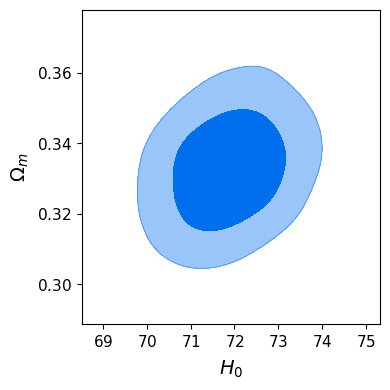

In [21]:
# Here we neglect the first burnin samples
burnin = 20
samps2 = sampler2.chain[:, burnin:, :].reshape((-1, ndim))

# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names2 = ["H_0", "\Omega_m", "M", "\sigma_8", "x_1", "x_2"]
labels2 = ["H_0", "\Omega_m", "M", "\sigma_8", "x_1", "x_2"]

samples2 = MCSamples(samples=samps2, names=names2, labels=labels2)

# Triangle plot
g = plots.get_subplot_plotter(width_inch=6)
#pl.figure(figsize=(50,30))z
g.triangle_plot([samples2], filled=True)
g.export('hrd_vs_om_case_all.pdf')

# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([samples2], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Compute the quantiles.

h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samps2, [16, 50, 84],
                                               axis=0)))
print("""MCMC result:
    $H0$        = {0[0]} + {0[1]} -{0[2]}
    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
    $M$         = {2[0]} + {2[1]} -{2[2]}
    $\Sigma_8$  = {3[0]} + {3[1]} -{3[2]}
    $x1$        = {4[0]} + {4[1]} -{4[2]}
    $x2$        = {5[0]} + {5[1]} -{5[2]}

""".format(h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc, x1_mcmc, x2_mcmc ))


# Statistical analysis of model with best-fit parameters

In [22]:
# Durbin-Watson statistic 

def resids_BAO(om, H0, x1, x2): 
    return np.array([dv(0.3, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2) -7.93, dm(0.51, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2) -13.62, dh(0.51, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2) -20.98, dm(0.71, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-16.85, dh(0.71, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-20.08, dm(0.93, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-21.71, dh(0.93, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-17.88, dm(1.32, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-27.79, dh(1.32, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-13.82, dv(1.49, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-26.07, dm(2.33, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-39.71, dh(2.33, om, H0, x1, x2)/rd2(zd, om, H0, x1, x2)-8.52])

def resids_SN1a(H0, om, M, x1, x2):
    dm = np.zeros(len(z_pp))
    for i in range(0, len(z_pp)):
        if hostyn_pp[i] == 1:
            dm[i] = mz_pp[i] - M - muceph_pp[i] # SH0ES calibrated \mu
        else:
            dm[i] = mz_pp[i] - mz_qd(z_pp[i], H0, om, M, x1, x2)
    return dm

def resids_RDS(om, sig8, x1, x2):
    model = fs8z(zgf, om, sig8, x1, x2)
    return (gf - model)
    
def resids(H0, om, M, sig8, x1, x2):
    residstot = np.concatenate((resids_BAO(om, H0, x1, x2), resids_SN1a(H0, om, M, x1, x2), resids_RDS(om, sig8, x1, x2)))
    return residstot

from statsmodels.stats.stattools import durbin_watson


In [23]:
# Flat XCDM
def chitotal(H0, om, M, sig8,  x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    SN1a = chi2_SN1a(H0, om, M, x1, x2)
    RDS = chi2_RDS(om, sig8, x1, x2)
    return BAO + SN1a + RDS
print("BAO+RDS+SN1a: chi-squared =", chitotal(73.38, 0.348, -19.25, 0.721, 0.37, -1.69))
print("BAO+RDS+SN1a: reduced chi-squared =",chitotal(73.38, 0.348, -19.25, 0.721, 0.37, -1.69)/(1776-6))
print("BAO+RDS+SN1a: DW statistic =", durbin_watson(resids(73.38, 0.348, -19.25, 0.721, 0.37, -1.69)))


BAO+RDS+SN1a: chi-squared = 1568.7450965848582
BAO+RDS+SN1a: reduced chi-squared = 0.886296664737208
BAO+RDS+SN1a: DW statistic = 1.720172125059245


In [24]:
# Flat XCDM + theta*
def chitotal(H0, om, M, sig8, x1, x2):
    BAO = chi2a(om, H0, x1, x2)+chi2b(om, H0, x1, x2)+chi2c(om, H0, x1, x2)+chi2d(om, H0, x1, x2)+chi2e(om, H0, x1, x2)+chi2f(om, H0, x1, x2)+chi2g(om, H0, x1, x2)
    SN1a = chi2_SN1a(H0, om, M, x1, x2)
    RDS = chi2_RDS(om, sig8, x1, x2)
    return BAO + SN1a + RDS + ((angle(z_recomb, om, H0, x1, x2)-1.04109)/0.00030)**2.
print("BAO+RDS+SN1a+theta*: chi-squared =", chitotal(72.33, 0.335, -19.28, 0.731, 0.42, -1.74))
print("BAO+RDS+SN1a+theta*: reduced chi-squared =",chitotal(72.33, 0.335, -19.28, 0.731, 0.42, -1.74)/(1776-7))
print("BAO+RDS+SN1a+theta*: DW statistic =", durbin_watson(resids(72.33, 0.335, -19.28, 0.731, 0.42, -1.74)))

BAO+RDS+SN1a+theta*: chi-squared = 2019.6245649645791
BAO+RDS+SN1a+theta*: reduced chi-squared = 1.141675842263753
BAO+RDS+SN1a+theta*: DW statistic = 1.7374417701076963


In [26]:
plot_filename = 'triangleplotXCDM.png'  # or any other format like .pdf, .jpg, etc.
g.export(plot_filename)

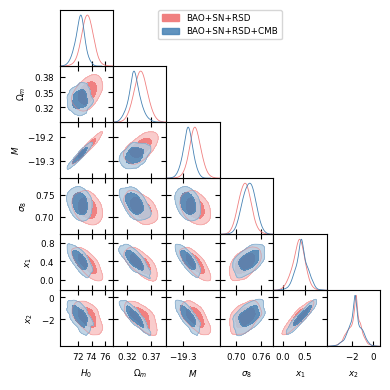

In [25]:

g.settings.axes_labelsize = 12
g.settings.axes_fontsize = 12
g.settings.legend_fontsize = 12
g.triangle_plot([samples1, samples2], filled = True, legend_labels = ['BAO+SN+RSD', 'BAO+SN+RSD+CMB'], contour_colors = ['lightcoral', 'steelblue'])

